## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
import pandas as pd
os.chdir('..')
import virl
from matplotlib import pyplot as plt
from collections import deque, namedtuple
from operator import attrgetter
import random

from IPython import display

In [2]:
# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

from tensorflow import where as tf_where

## Agent Implementation

In [3]:
class NNFunctionApproximatorJointKeras():
    """ A basic MLP neural network approximator and estimator using Keras     
    """
    
    def __init__(self, learning_rate, d_states, n_actions, nn_config, verbose=False):        
        self.learning_rate = learning_rate 
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)
        self.model = self._build_model()  
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf_where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.learning_rate, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return


In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'new_state', 'reward'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memory.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

In [5]:
def extract_samples(memory, batch_size):
    transitions = memory.sample(batch_size*2)
    best_transitions = sorted(transitions, key=attrgetter("reward"), reverse=True)
    transitions = best_transitions[:batch_size]
    batch = Transition(*zip(*transitions))
    train_rewards = np.array(batch.reward)
    train_states = np.array(batch.state)
    train_new_state = np.array(batch.new_state)
    train_actions = np.array(batch.action)
    return train_rewards, train_states, train_new_state, train_actions

def plot(all_rewards, smoothed_rewards):
    plt.figure(2, figsize=(12, 6))
    plt.clf()
    plt.title("Training")
    plt.xlabel("Epsiode")
    plt.ylabel("Total Reward")
    plt.plot(all_rewards, '--', alpha=0.5)
    plt.plot(smoothed_rewards)
    plt.legend(["Rewards", "Rewards (Smoothed)"])
    plt.pause(0.0001)
    display.clear_output(wait=True)
    
def init_env():
    env = virl.Epidemic(stochastic=False, noisy=False)
    return (env, env.action_space.n, env.observation_space.shape[0])
    
def init_networks(n_actions, d_states, learning_rate=0.001, nn_config=[24,24]):
    # Init the two networks
    policy_network = NNFunctionApproximatorJointKeras(learning_rate, d_states, n_actions, nn_config)
    target_network = NNFunctionApproximatorJointKeras(learning_rate, d_states, n_actions, nn_config)
    target_network.model.set_weights(policy_network.model.get_weights())
    
    return (policy_network, target_network)

def qlearning_nn(policy_network, target_network, env, n_actions, d_states, batch_size=104, replay_memory_size=512, num_episodes=3000, epsilon_decay=0.999986, window_size=50):
    memory = ReplayMemory(replay_memory_size)

    epsilon = 1
    discount_factor = 0.95
    
    all_rewards = []
    for episode in range(num_episodes):
        rewards = []
        
        state = env.reset()
        state = np.reshape(state, [1, d_states])
        
        exploits = 0
        done = False
        while not done:
            random_number = np.random.random()
            if random_number < epsilon and episode < (num_episodes-5):
                #explore
                action = np.random.choice(n_actions)
            else:
                #exploit
                exploits += 1
                action = policy_network.predict(state)[0]
                action = np.argmax(action)

            new_state, reward, done, i = env.step(action=action)
            new_state = np.reshape(new_state, [1, d_states])
            rewards.append(reward)
            
            memory.push(state, action, new_state, reward)
       
            state = new_state
            epsilon *= epsilon_decay
        
            if done:
                if len(memory) >= batch_size*2 and policy_network.learning_rate > 0:
                    # Fetch a batch from the replay buffer and extract as numpy arrays 
                    train_rewards, train_states, train_new_state, train_actions = extract_samples(memory, batch_size)

                    q_values_for_current_state = policy_network.predict(train_states.reshape(batch_size,d_states)) # predict current values for the given states
                    q_values_for_new_state     = target_network.predict(train_new_state.reshape(batch_size,d_states))                    
                    q_values_for_current_state_tmp = train_rewards + discount_factor * np.amax(q_values_for_new_state,axis=1)                
                    q_values_for_current_state[ (np.arange(batch_size), train_actions.reshape(batch_size,).astype(int))] = q_values_for_current_state_tmp                                                                              
                    policy_network.update(train_states.reshape(batch_size,d_states), q_values_for_current_state) # Update the function approximator 
                
                if episode % 100 == 0:
                    target_network.model.set_weights(policy_network.model.get_weights())
                total_reward = np.sum(rewards)
                all_rewards.append(total_reward)
                
                ## taking moving average of rewards to smooth
                smoothed_rewards = pd.Series(all_rewards).rolling(window_size, min_periods=window_size).mean()
                this_smoothed_reward = smoothed_rewards.values[-1]
                
                print("Episode = " + str(episode) + ". Epsilon = " + str(epsilon) + ". Num Exploits = " + str(exploits) + ". Total Reward = " + str(total_reward)
                          + ". Moving Average Reward = " + str(this_smoothed_reward))
                        
                plot(all_rewards, smoothed_rewards)        
    
    return all_rewards

In [ ]:
env, n_actions, d_states = init_env()
policy_network, target_network = init_networks(n_actions, d_states)
rewards = qlearning_nn(policy_network, target_network, env, n_actions, d_states)

# Training

Episode = 1644. Epsilon = 0.3019274920467005. Num Exploits = 36. Total Reward = -1.6219925161708209. Moving Average Reward = -1.5320121543858807


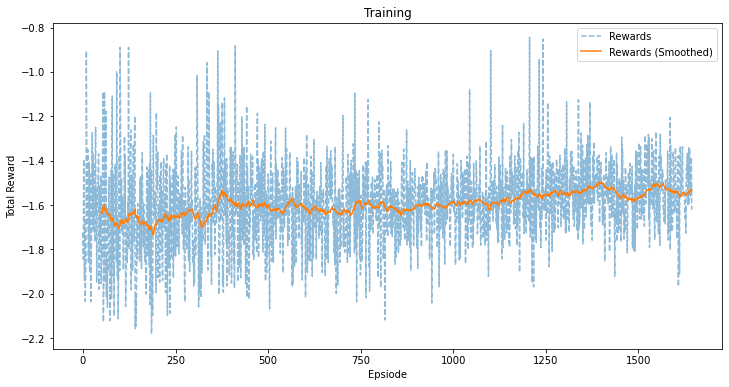

In [ ]:
all_rewards = qlearning_nn(batch_size=104, replay_memory_size=520, num_episodes=3000, epsilon_decay=0.999986)

# Evaluation

In [ ]:
def check_epsilon_after(decay, after_episodes):
    return (decay**52)**after_episodes

print(check_epsilon_after(0.99997, 500))
print(check_epsilon_after(0.99997, 1000))
print(check_epsilon_after(0.999986, 1000))
print(check_epsilon_after(0.999986, 2000))
print(check_epsilon_after(0.999986, 3000))